In [1]:
import chess
import torch
import util
import chess
import pickle
import pandas as pd
from copy import deepcopy


In [2]:
# add to path
import sys
sys.path.append('../')

In [3]:
import Heuristics

pygame 2.3.0 (SDL 2.24.2, Python 3.11.2)
Hello from the pygame community. https://www.pygame.org/contribute.html
0
0


In [ ]:
games_csv = pd.read_csv('./data/chess_games.csv')

In [3]:
# check if elos above 2000
elos = games_csv[(games_csv['WhiteElo'] > 2000)]

In [12]:
# print column names
print(games_csv.columns)

Index(['Event', 'White', 'Black', 'Result', 'UTCDate', 'UTCTime', 'WhiteElo',
       'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 'ECO', 'Opening',
       'TimeControl', 'Termination', 'AN'],
      dtype='object')


In [95]:
# filter moves by rating threshold and no draws
games = games_csv[(games_csv['Result'] != '1/2-1/2') & (games_csv['Result'] != '*') & (games_csv['WhiteElo'] > 2300) & (games_csv['WhiteElo'] < 2310)]
print(len(games))
# reindex



8771


In [ ]:
# check 

In [4]:
games = games.reset_index(drop=True)

moves = games['AN']
winners = games['Result']


In [15]:
board = chess.Board()
game1 = games['AN'][0]

In [ ]:
# split and check if move is legal
for move in game1.split():
    if chess.Move.from_uci(move) in board.legal_moves:
        board.push(chess.Move.from_uci(move))
    else:
        print('illegal move')
        break

In [5]:
games_csv = None

In [5]:
len(moves)

8771

In [3]:
move_distribution = pickle.load(open('../data/move_distribution_filtered_by_1800_winloss_based.pkl', 'rb'))

In [ ]:
file = open('./data/move_distribution_all_games_all_zeros_filter_by_1800.pkl', 'rb')

In [11]:
move_distribution[list(move_distribution.keys())[0]].keys()

dict_keys(['total', 'rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/8/4P3/PPPP1PPP/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/1P6/8/P1PPPPPP/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/8/2P5/PP1PPPPP/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/8/5N2/PPPPPPPP/RNBQKB1R', 'rnbqkbnr/pppppppp/8/8/8/6P1/PPPPPP1P/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/8/2N5/PPPPPPPP/R1BQKBNR', 'rnbqkbnr/pppppppp/8/8/8/3P4/PPP1PPPP/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/7P/8/PPPPPPP1/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/8/P7/1PPPPPPP/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/5P2/8/PPPPP1PP/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/6P1/8/PPPPPP1P/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/8/5P2/PPPPP1PP/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/P7/8/1PPPPPPP/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/8/N7/PPPPPPPP/R1BQKBNR', 'rnbqkbnr/pppppppp/8/8/8/7P/PPPPPPP1/RNBQKBNR', 'rnbqkbnr/pppppppp/8/8/8/7N/PPPPPPPP/RNBQKB1R'])

In [13]:
# preprocess distribution data

states = []
values = []
positions = 0
file_index = 0
heuristic = Heuristics.Heuristics()

maxkeys = len(move_distribution.keys())
current = 0

for key1 in move_distribution.keys():
    current += 1
    print (f'{current}/{maxkeys}', end="\r")
    #maxofkeys = max(move_distribution[key1].values()) / move_distribution[key1]['total']
    for key2 in move_distribution[key1].keys():
        
        # if move_distribution[key1]['total'] <= 1:
        #     continue 

        if key2 == 'total':
            continue

        initialpostion = chess.Board(key1)
        checkingposition = chess.Board(key2)
        move_prob = torch.tensor(move_distribution[key1][key2][0] / move_distribution[key1][key2][1])
        #print(move_prob)

        material_heuristic = heuristic.piece_values(checkingposition)

        state = util.return_model_input(initialpostion, checkingposition, material_heuristic)
        states.append(state)
        values.append(move_prob)

        if positions % 512 == 0 and positions != 0:
            states = torch.stack(states)
            values = torch.stack(values)
            batch = (states, values)
            torch.save(batch, f'C:/Dev/ChessBotExtraData/move_distribution_filtered_by_1800_winloss_based/batchdist_{file_index}.pt')
            file_index += 1

            states = []
            values = []
            board_fens = []

        positions += 1



RuntimeError: [enforce fail at ..\caffe2\serialize\inline_container.cc:337] . unexpected pos 384 vs 299

In [6]:
# loop through each game
states = []
values = []
board_fens = []
file_index = 1
positions = 1
for i in range(len(moves)):

    # if i % 2500 == 0 and i != 0:
    #     # save states and values
    #     pickle.dump(lichess_1800_states, open('./data/lichess_1200_states' + str(file_index) + '.pkl', 'wb'))
    #     pickle.dump(lichess_1800_values, open('./data/lichess_1200_values' + str(file_index) + '.pkl', 'wb'))
    #     lichess_1800_states.clear()
    #     lichess_1800_values.clear()
    #     file_index += 1
    #     print('saving ' + str(file_index))

    print(f'{i/len(moves)*100:.5f}%', end='\r')
    game = moves[i]
    winner = True if winners[i] == '1-0' else False
    board = chess.Board()
    move_num = 1
    for move in game.split():
        
        try:
            board.parse_san(move)
        except:
            continue

        board_fens.append(board.board_fen())

        board.push_san(move)

        state = util.one_hot_board(util.board_to_list(board)).unsqueeze(0)
        state[0][13] *= (1.0 if board.turn == True else -1.0)

        states.append(state)

        
            
        #state[0][13] += (1.0 / move_num)
        #state[0][13] *= (1.0 if board.turn == True else -1.0)
        # lichess_1800_states.append(state)
        
        #values.append(torch.tensor([1.0 if winner else -1.0]))
        values.append(torch.tensor([-(board.turn * 2.0 - 1.0)]))

        # check if move string is valid
        
        if positions % 512 == 0:
            states = torch.stack(states)
            values = torch.stack(values)
            batch = (states, values, board_fens)
            torch.save(batch, f'./data/ahhv2/batch2200_{file_index}.pt')
            file_index += 1

            states = []
            values = []
            board_fens = []

        
        positions += 1

        move_num += 1

states = torch.stack(states)
values = torch.stack(values)
batch = (states, values)
torch.save(batch, f'./data/ahhv2/batch2200_{file_index}.pt')

states = []
values = []

# pickle.dump(lichess_1800_states, open('./data/lichess_1200_states' + str(file_index) + '.pkl', 'wb'))
# pickle.dump(lichess_1800_values, open('./data/lichess_1200_values' + str(file_index) + '.pkl', 'wb'))
# lichess_1800_states.clear()
# lichess_1800_values.clear()

In [51]:
class ChessDataset(torch.utils.data.Dataset):
    def __init__(self):
        # self.states = states
        # self.values = values
        pass
    def __len__(self):
        return 29999 # max around 7500

    def __getitem__(self, idx):
        return torch.load(f'C:/Dev/ChessBotExtraData/move_distribution_filtered_by_1800_winloss_based/batchdist_{idx+1}.pt')
        #return torch.load(f'C:/Dev/ChessBotExtraData/alotof_states/batchdist_{idx+1}.pt')
        #return torch.load(f'./data/ahhv2/batch2200_{idx+1}.pt')
        # if idx > 9999:
        #     return torch.load(f'C:/Dev/ChessBotExtraData/move_dist_states/batchdist_{idx+1}.pt')
        # return torch.load(f'./data/move_dist_filter_2200/batchdist_{idx+1}.pt')


In [52]:
deeta = ChessDataset()

In [5]:
import torch
from torch import nn
from architecture import SimpleValueNetwork
import pickle
import torchsummary
import random

In [6]:
import neural_net_methods.alphazero_rl as alphazero_rl

In [307]:
# reload sigmazero
import importlib
importlib.reload(alphazero_rl)

<module 'sigmazero' from 'g:\\Dev\\ChessBot\\sigmazero.py'>

In [19]:
# lichess_1800_states = pickle.load(open('./data/lichess_1800_states.pkl', 'rb'))
# lichess_1800_values = pickle.load(open('./data/lichess_1800_values.pkl', 'rb'))

# shuffle
import random
c = list(zip(lichess_1800_states, lichess_1800_values))
random.shuffle(c)
lichess_1800_states, lichess_1800_values = zip(*c)


In [62]:
lichess_1800_states = pickle.load(open('./data/lichess_1800_states.pkl', 'rb'))
lichess_1800_values = pickle.load(open('./data/lichess_1800_values.pkl', 'rb'))

In [20]:
pickle.dump(lichess_1800_states, open('./data/lichess_1600_states.pkl', 'wb'))
pickle.dump(lichess_1800_values, open('./data/lichess_1600_values.pkl', 'wb'))

In [7]:
DEVICE = "cuda"

In [56]:
nnet = nnet.to(DEVICE)

In [9]:
nnet = SimpleValueNetwork(256).to(DEVICE)
nnet.load_state_dict(torch.load('../models/10000_batches_filtered_by_2200__256_neurons.pth'))
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)
criterion = nn.MSELoss().to(DEVICE)

In [9]:
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.00001)

In [8]:
BATCH_SIZE = 512

In [91]:
batches = []
for i in range(0, len(lichess_1800_states), BATCH_SIZE):
    batches.append((torch.cat(lichess_1800_states[i:i+BATCH_SIZE]).squeeze(), torch.cat(lichess_1800_values[i:i+BATCH_SIZE])))

In [9]:
# clear memory
lichess_1800_states = None
lichess_1800_values = None

In [10]:
import random

In [53]:
losses = []

In [17]:
# load all batches
batches = []

for pickles in range(1, 3):
    lichess_1800_states = pickle.load(open('./data/lichess_1200_states' + str(pickles) + '.pkl', 'rb'))
    lichess_1800_values = pickle.load(open('./data/lichess_1200_values' + str(pickles) + '.pkl', 'rb'))


    for i in range(0, len(lichess_1800_states), BATCH_SIZE):
        batches.append((torch.cat(lichess_1800_states[i:i+BATCH_SIZE]).squeeze(), torch.cat(lichess_1800_values[i:i+BATCH_SIZE])))
    # shuffle batches

In [20]:
deeta[4][2].shape

IndexError: tuple index out of range

In [54]:
# make dataloader
dataloader = torch.utils.data.DataLoader(deeta, batch_size=1, shuffle=True)

In [13]:
# trying to reduce model size as much as possible
# try to reach .01 loss

In [57]:
for epoch in range(1000000):
    # save model
    torch.save(nnet.state_dict(), '../models/30000_batches_filtered_by_1800__256_neurons_winloss_based.pth')
    for i, batch in enumerate(dataloader):

        for j in range(1):
            # loss2 = torch.tensor([0.0]).to(DEVICE)
            # lastloss = 0
 
            # if random.random() < 1.0:

            #     negative_states = []
            #     negative_values = []
            #     for cheese in batch[2]:
            #         board = chess.Board(cheese[0])
            #         legalmoves = list(board.legal_moves)
            #         if board.is_game_over():

            #             state = util.one_hot_board(util.board_to_list(board)).unsqueeze(0)
            #             state[0][13] *= (1.0 if board.turn == True else -1.0)

            #             negative_states.append(state)
            #             negative_values.append(torch.tensor([-(board.turn * 2.0 - 1.0)]))
            #             continue

                    
            #         board.push(random.choice(legalmoves))

            #         state = util.one_hot_board(util.board_to_list(board)).unsqueeze(0)
            #         state[0][13] *= (1.0 if board.turn == True else -1.0)



            #         negative_states.append(state)
            #         negative_values.append(torch.tensor([(board.turn * 2.0 - 1.0)]))

            #     negative_states = torch.stack(negative_states)
            #     negative_values = torch.stack(negative_values)

            #     negative_states = negative_states.to(DEVICE)
            #     negative_states = negative_states.squeeze().reshape(-1, 64*14)


            #     negative_values = negative_values.to(DEVICE)
            #     pred2 = nnet(negative_states)

            #     #p#rint(pred)
            #     optimizer.zero_grad() 
            #     loss2 = criterion(pred2.squeeze(), negative_values.squeeze().squeeze())
            
              
            # loss2.backward()
            # optimizer.step()
            #losses.append(loss2.item())



            state = batch[0].to(DEVICE)
            #state = state.squeeze().reshape(-1, 64*14)
            value = batch[1].to(DEVICE)
            pred1 = nnet(state)

            #p#rint(pred)
            loss1 = criterion(pred1.squeeze(), value.squeeze().squeeze())
            # optimizer.zero_grad()
            # loss1.backward()
            # optimizer.step()
            
            
            #lastloss = (-((nnet(state).squeeze() - nnet(negative_states).squeeze())**2.0)+1.0).mean()
            #lass = (loss2 + loss1)
            optimizer.zero_grad()
            loss1.backward()
            optimizer.step()
            losses.append(loss1.item())
            
            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            # losses.append(loss.item())

            

            if len(losses) > 100:
                losses.pop(0) 
            avg_loss = sum(losses) / len(losses)
            print(f'Epoch: {epoch}, Batch Percent: {i/len(deeta)*100:.2f}%, Loss1: {loss1.item()} Avg Loss: {avg_loss}', end='\r')

KeyboardInterrupt: 

<h2>Pit Against Itself</h2>

<h5>Test Move Mirroring</h5>

In [31]:
testboard = chess.Board()
print(testboard.legal_moves)
move = testboard.parse_san('e4')
print(move)
mirroredboard = testboard.mirror()
testboard.push(move)
print(testboard)
#print(testboard.legal_moves)
mirrored_move = chess.Move(from_square=chess.square_mirror(move.from_square), to_square=chess.square_mirror(move.to_square))
print(mirrored_move)
mirroredboard.push(mirrored_move)
print(mirroredboard.mirror())
#testboard.push(mirrored_move)


<LegalMoveGenerator at 0x26d30dd6550 (Nh3, Nf3, Nc3, Na3, h3, g3, f3, e3, d3, c3, b3, a3, h4, g4, f4, e4, d4, c4, b4, a4)>
e2e4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
e7e5
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R


<h5>Pit</h5>

In [10]:
nnet = nnet.to('cpu')

In [11]:
board = chess.Board()

In [24]:
import Heuristics

pygame 2.3.0 (SDL 2.24.2, Python 3.11.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [28]:
nnet.load_state_dict(torch.load('../models/10000_batches_filtered_by_2200__256_neurons.pth'))

<All keys matched successfully>

In [12]:
nummove = 0

In [13]:
del max

NameError: name 'max' is not defined

[0.22306708991527557, 0.2863484025001526, 0.4017045795917511, 0.4334123134613037, 0.5352088809013367, 0.4710223078727722, 0.7940955758094788, -0.003283485770225525, 0.057274043560028076, 0.012359684333205223, 0.08947387337684631, 0.03546469658613205, 0.031600601971149445, 0.009298626333475113, 0.006798082962632179, 0.009664749726653099, 0.0030929092317819595, 0.22977285087108612, 0.08418354392051697, 0.07164003700017929, 0.05467040836811066, 0.11357279866933823, 0.5337141156196594, 0.12239006161689758, 0.11180076003074646, 0.03739297017455101, 0.06038615107536316, 0.05699216574430466, 0.024912897497415543, 0.0762304738163948, 0.06784976273775101, 0.053585268557071686, 0.1891975700855255, 0.2996870279312134, 0.48958221077919006, 0.02856411226093769, 0.04642079025506973, 0.08485782146453857, 0.04676704853773117, 0.028087301179766655, 0.05250153690576553, 0.08886564522981644, 0.07071381062269211]
26


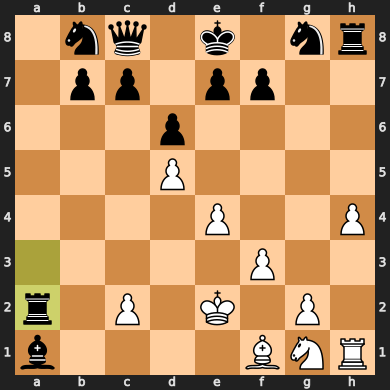

In [44]:
values = []
tempinitialboard = deepcopy(board)
heuristic = Heuristics.Heuristics()
if tempinitialboard.turn == chess.BLACK:
    tempinitialboard = tempinitialboard.mirror()

legalmoves = list(tempinitialboard.legal_moves)
for move in legalmoves:
    tempcheckingboard = deepcopy(tempinitialboard)
    tempcheckingboard.push(move)
    piece_values = heuristic.material_values(tempcheckingboard)
    state = util.return_model_input(tempinitialboard, tempcheckingboard, piece_values)
    value = nnet(state)
    values.append(value.item())


# sample move
print(values)
#best_move = random.choices(legalmoves, weights=values)[0]



best_move = legalmoves[values.index(max(values))]

if board.turn == chess.BLACK:
    # mirror move
    best_move = chess.Move(chess.square_mirror(best_move.from_square), chess.square_mirror(best_move.to_square))
nummove +=1 
print(nummove)
board.push(best_move)
board

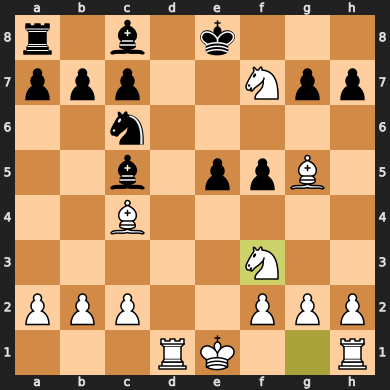

In [300]:
board.push_uci("g1f3")
board

In [266]:
board = chess.Board()

In [298]:
board.pop()

Move.from_uci('c6d4')

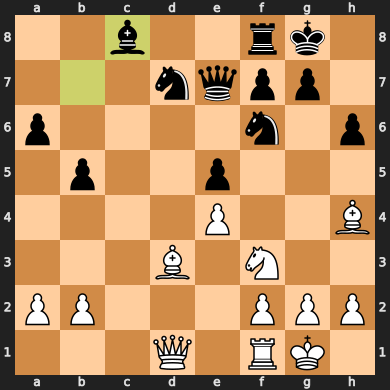

In [90]:
board

In [12]:
# save model
torch.save(nnet.state_dict(), './models/lichess_2200_simplevaluenet3.pth')

In [106]:
import chess
import util

In [13]:
nnet = nnet.to("cpu")

In [14]:
test_board = chess.Board()

In [40]:
test_board.push_san("Nc3")

Move.from_uci('b1c3')

In [11]:
state = util.one_hot_board(util.board_to_list(test_board)).unsqueeze(0)
            
# state[0][13] += (1.0 / 1)
# state[0][13] *= (1.0 if test_board.turn == True else -1.0)

value = nnet(state)
value

tensor([[0.2658]], grad_fn=<TanhBackward0>)

In [79]:
test_board.push_san("Qh5")

Move.from_uci('d1h5')

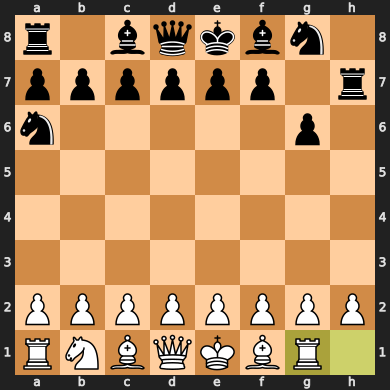

In [19]:
test_board

In [89]:
nnet.load_state_dict(torch.load('./models/lichess_1800.pth'))

<All keys matched successfully>

In [115]:
move_num = 4

In [55]:
test_board = chess.Board()

tensor([[-0.9999]], grad_fn=<AddmmBackward0>)
f3g5 -1.01 f3h4 -1.00 f3d2 -1.04 f3g1 -1.03 c3d5 0.23 c3b5 -1.02 c3e4 0.34 c3a4 -1.01 c3e2 -1.03 c3b1 -0.92 h1g1 -1.00 f1a6 -1.00 f1b5 -0.73 f1c4 -1.01 f1d3 0.10 f1e2 -1.03 e1e2 -1.00 d1d3 -0.94 d1e2 -1.04 d1d2 -1.02 c1g5 -1.02 c1f4 -1.01 c1e3 -0.98 c1d2 -1.02 a1b1 -1.00 e5e6 -0.70 d4d5 0.43 h2h3 -0.97 g2g3 -1.02 b2b3 -0.99 a2a3 -1.02 h2h4 0.45 g2g4 -1.00 b2b4 -1.02 a2a4 -1.00 
h2h4 0.4468488097190857


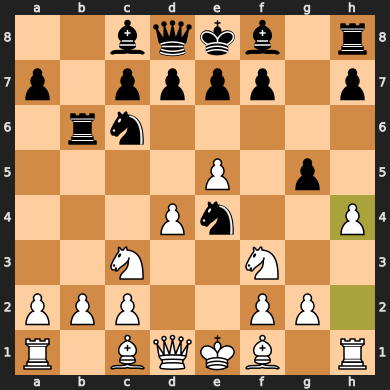

In [70]:
# value every move
legal_moves = list(test_board.legal_moves)
def eval_move(move):
    test_board.push(move)
    state = util.one_hot_board(util.board_to_list(test_board)).unsqueeze(0)
            
    state[0][13] += (1.0 / 2)
    state[0][13] *= (1.0 if test_board.turn == True else -1.0)

    value = nnet(state)
    test_board.pop()
    return -value

values = []

state = util.one_hot_board(util.board_to_list(test_board)).unsqueeze(0)
            
    # state[0][13] += (1.0 / 2)
state[0][13] *= (1.0 if test_board.turn == True else -1.0)

print(nnet(state))


for move in legal_moves:
    test_board.push(move)
    state = util.one_hot_board(util.board_to_list(test_board)).unsqueeze(0)
            
    # state[0][13] += (1.0 / 2)
    state[0][13] *= (1.0 if test_board.turn == True else -1.0)
    value = nnet(state)
    values.append(value.item())
    print(move, f"{value.item():.2f}", end=" ")
    test_board.pop()

# get index of max
if test_board.turn == True:
    max_index = values.index(max(values))
else:
    max_index = values.index(min(values))


# move = mcts(Node(test_board), test_board, nnet, 800, move_num, "cpu", True)
test_board.push(legal_moves[max_index])
print("\n"+str(legal_moves[max_index]) + " " + str(values[max_index]))
# print(move)
# move_num += 1
# test_board
test_board

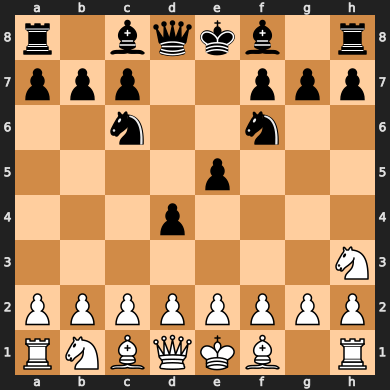

In [32]:
test_board.mirror()

In [48]:
test_board.push_san("g8f6")

Move.from_uci('g8f6')

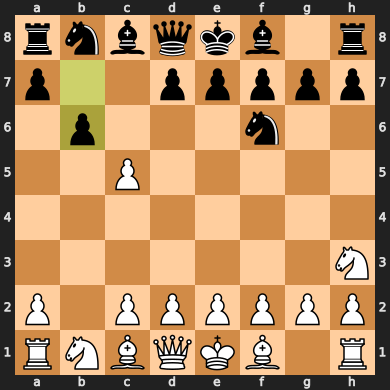